In [156]:
import os
import pandas as pd
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_community.document_loaders import UnstructuredExcelLoader
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables import Runnable
from langchain.chains import create_retrieval_chain
from langchain.memory import ConversationBufferMemory
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import MessagesState
from langchain_core.messages import HumanMessage, AIMessage
import re

load_dotenv()

True

In [157]:
# Global model used across both tools and RAG
llm = ChatGroq(
    api_key=os.getenv("GROQ_API_KEY"),
    model_name="Qwen-Qwq-32b",
    temperature = 0.2
)


In [158]:
#File loader tool: Reads and preprocesses all 2 Excel files into structured DataFrames
def load_excel_files():
    file_paths = [
        "2025_06_20_D0_pre_opti_model.xlsx",
        "2025_06_20_D0_load_cost_analysis_post_optimisation.xlsx"
    ]
    dfs = {}
    for path in file_paths:
        if not path or not os.path.exists(path):
            print(f"Warning: File {path} not found")
            continue
        try:
            sheet_dfs = pd.read_excel(path, sheet_name=None)
            for sheet_name, df in sheet_dfs.items():
                key = f"{os.path.basename(path).replace('.xlsx','')}__{sheet_name}".lower()
                dfs[key] = df
        except Exception as e:
            print(f"Error loading {path}: {e}")
    return dfs

# Load structured data
structured_dfs = load_excel_files()

In [159]:
# File descriptions for context
FILE_DESCRIPTIONS = {
    "pre_opti_model": {
        "description": "Contains raw SKU data before optimization including alternate SKUs, demand forecasts, risk assessments, and original planning data",
        "key_fields": ["material_sk", "alternate skus", "demand_at_dt", "%_At_Risk", "Action", "lcp_rank", "weights", "chosen"],
        "use_cases": [
            "alternate SKUs information",
            "Reason for chosing particular SKU",
            "original demand data",
            "risk assessments", 
            "SKU characteristics",
            "planning weights",
            "unoptimized data"
        ]
    },
    "post_optimisation": {
        "description": "Contains optimized load assignments, cost analysis, and final allocation decisions after optimization",
        "key_fields": ["load_id", "material_sk", "optimized_quantity", "cost_analysis", "final_allocation"],
        "use_cases": [
            "load assignments",
            "optimized quantities",
            "cost analysis",
            "final allocations",
            "post-optimization results"
        ]
    }
}

In [ ]:
# %%
def query_router(question: str) -> dict:
    """
    Use LLM to intelligently route queries based on file descriptions and context.
    Returns both the tool and the preferred data source.
    """
    routing_prompt = f"""
    You are a query routing assistant for a supply chain optimization system. 
    
    Available data sources:
    1. PRE_OPTI_MODEL: {FILE_DESCRIPTIONS['pre_opti_model']['description']}
       - Key fields: {', '.join(FILE_DESCRIPTIONS['pre_opti_model']['key_fields'])}
       - Best for: {', '.join(FILE_DESCRIPTIONS['pre_opti_model']['use_cases'])}
    
    2. POST_OPTIMISATION: {FILE_DESCRIPTIONS['post_optimisation']['description']}
       - Key fields: {', '.join(FILE_DESCRIPTIONS['post_optimisation']['key_fields'])}
       - Best for: {', '.join(FILE_DESCRIPTIONS['post_optimisation']['use_cases'])}
    
    Available tools:
    - get_sku_info: Get detailed information about a specific SKU
    - get_skus_in_load: Get all SKUs assigned to a specific load
    - compare_skus: Compare multiple SKUs
    - get_alternate_skus: Get all alternate SKUs that can be sent in a specific load_id
    - structured_query_tool: For questions requiring numeric aggregation, counts, or filtering on tabular data (e.g., "how many SKUs", "count of load_ids", etc.)
    - rag_chain_tool: General questions requiring document search
    
    User question: "{question}"
    
    Based on the question, determine:
    1. Which tool is most appropriate
    2. Which data source(s) would best answer the question
    3. Brief reasoning for your choice
    
    Respond in this exact format:
    TOOL: [tool_name]
    DATA_SOURCE: [pre_opti_model|post_optimisation|both]
    REASONING: [brief explanation]
    """
    
    try:
        response = llm.invoke(routing_prompt)
        
        # Parse the response
        lines = response.content.strip().split('\n')
        result = {"tool": "rag_chain_tool", "data_source": "both", "reasoning": "Default routing"}
        
        for line in lines:
            if line.startswith("TOOL:"):
                result["tool"] = line.split(":", 1)[1].strip()
            elif line.startswith("DATA_SOURCE:"):
                result["data_source"] = line.split(":", 1)[1].strip()
            elif line.startswith("REASONING:"):
                result["reasoning"] = line.split(":", 1)[1].strip()
        
        return result
        
    except Exception as e:
        print(f"Error in smart routing: {e}")
        # Fallback to rule-based routing
        return fallback_query_router(question)
    
def fallback_query_router(question: str) -> dict:
    """Enhanced rule-based router as fallback."""
    q = question.lower()
    
    # Keywords that suggest pre-optimization data
    pre_opti_keywords = [
        "alternate", "alternative", "original", "demand", "forecast", 
        "risk", "at_risk", "weight", "lcp_rank", "characteristics",
        "planning", "unoptimized", "raw"
    ]
    
    # Keywords that suggest post-optimization data
    post_opti_keywords = [
        "optimized", "allocated", "assigned", "cost", "final", 
        "result", "outcome", "solution"
    ]
    
    # Determine data source preference
    pre_opti_score = sum(1 for keyword in pre_opti_keywords if keyword in q)
    post_opti_score = sum(1 for keyword in post_opti_keywords if keyword in q)
    
    if pre_opti_score > post_opti_score:
        data_source = "pre_opti_model"
    elif post_opti_score > pre_opti_score:
        data_source = "post_optimisation"
    else:
        data_source = "both"
    
    # Determine tool
    if re.search(r"(how many|number of)\s+(skus|loads?|load_ids?).*action.*(?:as|=|with)?\s*['\"]?(no change|swap-out \(delete\)|top-up \(new\)|top-up \(update\)|swap-in)['\"]?", q):
        tool = "structured_query_tool"
    elif "material_sk" in q and "compare" in q:
        tool = "compare_skus"
    elif "material_sk" in q and ("information" in q or "info" in q or "give" in q):
        tool = "get_sku_info"
    elif "load_id" in q:
        tool = "get_skus_in_load"
    elif "load_id" in q and "alternate" in q:
        tool = "get_alternate_skus"
    else:
        tool = "rag_chain_tool"
    
    return {
        "tool": tool,
        "data_source": data_source,
        "reasoning": f"Rule-based: Routed to {tool} due to structured keyword patterns or domain-specific fields."
    }    

In [161]:
# Tool definitions using @tool decorator
#tool to get information about specific SKUs by giving material_sk
@tool
def get_sku_info(question: str) -> str:
    """Get information for a specific SKU with smart data source selection."""
    routing_info = query_router(question)
    
    match = re.search(r"\bmaterial_sk\s+(\d+)\b", question)
    if not match:
        return "Please provide a valid material_sk number."
    
    sku_id = int(match.group(1))
    results = []
    
    # Search based on routing decision
    if routing_info["data_source"] in ["pre_opti_model", "both"]:
        for key, df in structured_dfs.items():
            if "pre_opti_model" in key and "material_sk" in df.columns:
                result = df[df["material_sk"] == sku_id]
                if not result.empty:
                    results.append(f"PRE-OPTIMIZATION DATA:\n{result.to_string(index=False)}")
    
    if routing_info["data_source"] in ["post_optimisation", "both"]:
        for key, df in structured_dfs.items():
            if "post_optimisation" in key and "material_sk" in df.columns:
                result = df[df["material_sk"] == sku_id]
                if not result.empty:
                    results.append(f"POST-OPTIMIZATION DATA:\n{result.to_string(index=False)}")
    
    if results:
        return f"SKU Information for material_sk {sku_id}:\n" + "\n\n".join(results) + f"\n\nRouting Decision: {routing_info['reasoning']}"
    else:
        return f"SKU with material_sk {sku_id} not found in the selected data sources."

In [162]:
#Tool to get information of all SKUs in a particular load_id
@tool
def get_skus_in_load(question: str) -> str:
    """Get all SKUs in a specific load with smart data source selection."""
    routing_info = query_router(question)
    
    match = re.search(r"\bload_id\s+(\d+)", question)
    if not match:
        return "Please provide a valid load_id number."
    
    load_id = int(match.group(1))
    results = []
    
    # For load queries, we might need to check both sources
    if routing_info["data_source"] in ["post_optimisation", "both"]:
        for key, df in structured_dfs.items():
            if "post_optimisation" in key and "load_id" in df.columns:
                skus = df[df["load_id"] == load_id]
                if not skus.empty:
                    results.append(f"POST-OPTIMIZATION LOAD DATA:\n{skus.to_string(index=False)}")
    
    # If question asks about alternates, also check pre-opti data
    if "alternate" in question.lower() or routing_info["data_source"] in ["pre_opti_model", "both"]:
        # Get SKUs from load first, then find their alternates in pre-opti data
        sku_ids = []
        for key, df in structured_dfs.items():
            if "post_optimisation" in key and "load_id" in df.columns:
                load_skus = df[df["load_id"] == load_id]
                if not load_skus.empty and "material_sk" in df.columns:
                    sku_ids.extend(load_skus["material_sk"].tolist())
        
        if sku_ids:
            for key, df in structured_dfs.items():
                if "pre_opti_model" in key and "material_sk" in df.columns:
                    alternate_info = df[df["material_sk"].isin(sku_ids)]
                    if not alternate_info.empty:
                        results.append(f"PRE-OPTIMIZATION DATA (for alternate analysis):\n{alternate_info.to_string(index=False)}")
    
    if results:
        return f"Information for load_id {load_id}:\n" + "\n\n".join(results) + f"\n\nRouting Decision: {routing_info['reasoning']}"
    else:
        return f"No information found for load_id {load_id}."

In [163]:
#Tool to compare two different SKUs given their material_sk
@tool
def compare_skus(question: str) -> str:
    """Compare two SKUs with smart data source selection."""
    routing_info = query_router(question)
    
    ids = re.findall(r"\bmaterial_sk\s+(\d+)", question)
    if len(ids) != 2:
        return "Please provide exactly two material_sk IDs for comparison."
    
    sku_ids = [int(id_str) for id_str in ids]
    results = []
    
    # Search based on routing decision
    if routing_info["data_source"] in ["pre_opti_model", "both"]:
        for key, df in structured_dfs.items():
            if "pre_opti_model" in key and "material_sk" in df.columns:
                rows = df[df["material_sk"].isin(sku_ids)]
                if not rows.empty:
                    results.append(f"PRE-OPTIMIZATION COMPARISON:\n{rows.to_string(index=False)}")
    
    if routing_info["data_source"] in ["post_optimisation", "both"]:
        for key, df in structured_dfs.items():
            if "post_optimisation" in key and "material_sk" in df.columns:
                rows = df[df["material_sk"].isin(sku_ids)]
                if not rows.empty:
                    results.append(f"POST-OPTIMIZATION COMPARISON:\n{rows.to_string(index=False)}")
    
    if results:
        return f"Comparison of material_sk {sku_ids[0]} and {sku_ids[1]}:\n" + "\n\n".join(results) + f"\n\nRouting Decision: {routing_info['reasoning']}"
    else:
        return f"Could not find both SKUs {sku_ids[0]} and {sku_ids[1]} for comparison."


In [164]:
@tool
def get_alternate_skus(question: str) -> str:
    """Suggest alternate SKUs for a given load_id using pre-opti data, excluding already selected SKUs."""
    import re
    import pandas as pd
    
    # Extract load_id - handle both string and numeric load_ids
    match = re.search(r"\bload_id\s+(\w+)", question, re.IGNORECASE)
    if not match:
        return "Please provide a valid load_id in your question (e.g., 'load_id 12345')."
    
    load_id_str = match.group(1)
    
    # Try to convert to int if it's numeric, otherwise keep as string
    try:
        load_id = int(load_id_str)
    except ValueError:
        load_id = load_id_str
    
    pre_df = None
    post_df = None
    pre_key = None
    post_key = None
    
    # Identify the correct pre and post optimization files
    for key, df in structured_dfs.items():
        if "pre_opti_model" in key.lower() and "load_id" in df.columns:
            # Check if this load_id exists in this dataframe
            temp_df = df[df["load_id"] == load_id]
            if not temp_df.empty:
                pre_df = temp_df.copy()
                pre_key = key
                break
    
    for key, df in structured_dfs.items():
        if "post_optimisation" in key.lower() and "load_id" in df.columns:
            # Check if this load_id exists in this dataframe
            temp_df = df[df["load_id"] == load_id]
            if not temp_df.empty:
                post_df = temp_df.copy()
                post_key = key
                break
    
    # Enhanced error handling
    if pre_df is None or pre_df.empty:
        available_pre_loads = []
        for key, df in structured_dfs.items():
            if "pre_opti_model" in key.lower() and "load_id" in df.columns:
                available_pre_loads.extend(df["load_id"].unique().tolist())
        
        if available_pre_loads:
            sample_loads = available_pre_loads[:5]  # Show first 5 as examples
            return f"No pre-optimization data found for load_id {load_id}. Available load_ids include: {sample_loads}..."
        else:
            return f"No pre-optimization data found for load_id {load_id}. No pre-optimization files with load_id column found."
    
    if post_df is None or post_df.empty:
        return f"No post-optimization data found for load_id {load_id}. Cannot determine which SKUs are already selected."
    
    # Ensure material_sk column exists in both dataframes
    if "material_sk" not in pre_df.columns:
        return f"material_sk column not found in pre-optimization data ({pre_key})."
    
    if "material_sk" not in post_df.columns:
        return f"material_sk column not found in post-optimization data ({post_key})."
    
    # Get SKUs used in post-optimization
    used_skus = set(post_df["material_sk"].unique())
    
    # Suggest alternate SKUs not used in post-optimization
    alternate_df = pre_df[~pre_df["material_sk"].isin(used_skus)].copy()
    
    if alternate_df.empty:
        return f"No alternate SKUs found for load_id {load_id}. All {len(used_skus)} SKUs from pre-optimization are already used in post-optimization."
    
    # Sort alternates by relevant criteria if columns exist
    sort_columns = []
    sort_ascending = []
    
    # Prioritize by demand (higher is better)
    if 'demand_at_dt(HL)' in alternate_df.columns:
        sort_columns.append('demand_at_dt(HL)')
        sort_ascending.append(False)
    elif 'demand' in alternate_df.columns:
        sort_columns.append('demand')
        sort_ascending.append(False)
    
    # Then by cost (lower is better)
    if 'vilc_cost' in alternate_df.columns:
        sort_columns.append('vilc_cost')
        sort_ascending.append(True)
    elif 'cost' in alternate_df.columns:
        sort_columns.append('cost')
        sort_ascending.append(True)
    
    # Then by LCP rank (lower is better)
    if 'lcp_rank' in alternate_df.columns:
        sort_columns.append('lcp_rank')
        sort_ascending.append(True)
    
    # Apply sorting if any sort columns were found
    if sort_columns:
        alternate_df = alternate_df.sort_values(sort_columns, ascending=sort_ascending)
    
    # Prepare summary information
    total_pre_skus = len(pre_df)
    total_post_skus = len(used_skus)
    total_alternates = len(alternate_df)
    
    # Get unique source-destination combinations
    unique_routes = None
    if 'source' in alternate_df.columns and 'destination' in alternate_df.columns:
        unique_routes = len(alternate_df.groupby(['source', 'destination']))
    
    # Prepare the result
    result_lines = []
    result_lines.append(f"ALTERNATE SKUs FOR LOAD_ID: {load_id}")
    result_lines.append("=" * 50)
    result_lines.append(f"Pre-optimization SKUs available: {total_pre_skus}")
    result_lines.append(f"Post-optimization SKUs selected: {total_post_skus}")
    result_lines.append(f"Alternate SKUs found: {total_alternates}")
    
    if unique_routes:
        result_lines.append(f"Unique source-destination routes: {unique_routes}")
    
    result_lines.append("")
    result_lines.append("Data sources:")
    result_lines.append(f"• Pre-optimization: {pre_key}")
    result_lines.append(f"• Post-optimization: {post_key}")
    result_lines.append("")
    
    # Show sorting criteria if applied
    if sort_columns:
        sort_desc = []
        for i, col in enumerate(sort_columns):
            direction = "descending" if not sort_ascending[i] else "ascending"
            sort_desc.append(f"{col} ({direction})")
        result_lines.append(f"Sorted by: {', '.join(sort_desc)}")
        result_lines.append("")
    
    result_lines.append("ALTERNATE SKUs DETAILS:")
    result_lines.append("-" * 30)
    
    # Limit columns to display for readability
    display_columns = ['material_sk', 'material_code'] if 'material_code' in alternate_df.columns else ['material_sk']
    
    # Add key columns if they exist
    key_columns = ['source', 'destination', 'demand_at_dt(HL)', 'vilc_cost', 'lcp_rank', 'OOS%']
    for col in key_columns:
        if col in alternate_df.columns:
            display_columns.append(col)
    
    # Ensure we don't exceed reasonable display width
    if len(display_columns) > 8:
        display_columns = display_columns[:8]
    
    # Display the results
    try:
        if len(alternate_df) > 20:
            result_lines.append("TOP 20 ALTERNATE SKUs:")
            result_lines.append(alternate_df[display_columns].head(20).to_string(index=False))
            result_lines.append(f"\n... and {len(alternate_df) - 20} more alternate SKUs available")
        else:
            result_lines.append(alternate_df[display_columns].to_string(index=False))
    except Exception as e:
        # Fallback to basic display if formatting fails
        result_lines.append("ALTERNATE SKUs (basic format):")
        result_lines.append(str(alternate_df.head(10)))
        result_lines.append(f"Error in detailed formatting: {str(e)}")
    
    return "\n".join(result_lines)

In [165]:
#To create a memory instance
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True,
    output_key="answer"
)

In [166]:
# Setup QA Chain for RAG
chat_histories = {}
def setup_qa_chain():
    """Set up the RAG chain for general questions."""
    documents = []
    
    # Load Excel files as documents
    file_paths = [
        "2025_06_20_D0_pre_opti_model.xlsx",
        "2025_06_20_D0_load_cost_analysis_post_optimisation.xlsx"
    ]
    
    for path in file_paths:
        if os.path.exists(path):
            try:
                loader = UnstructuredExcelLoader(path)
                docs = loader.load()
                documents.extend(docs)
            except Exception as e:
                print(f"Error loading {path} for RAG: {e}")
    
    if not documents:
        print("Warning: No documents loaded for RAG")
        return None
    
    # Create embeddings and vectorstore
    embeddings = HuggingFaceEmbeddings()
    vectorstore = FAISS.from_documents(documents, embeddings)
    
    # Create prompt template
    system_prompt = (
        "You are an assistant designed to provide clear and concise explanations for decision-making logic. "
        "When the user asks a question, analyze the underlying data, constraints, and priorities that could have influenced the choice. "
        "Always reason step-by-step using available context. Highlight key factors such as weights, %_At_Risk, Action, %_OOS, lcp_rank, or demand_at_dt(HL). "
        "If you are uncertain due to missing context, clearly state that and suggest what additional data would help. "
        "Keep explanations factual, structured, and under 4 sentences unless explicitly asked for a deeper dive."
        "\n\n{context}"
    )
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "{input}"),
    ])
    
    # Create RAG chain
    qa_chain = create_retrieval_chain(
        vectorstore.as_retriever(), 
        create_stuff_documents_chain(llm, prompt)
    )

    # add message history wrapper
    qa_chain_with_memory = RunnableWithMessageHistory(
        qa_chain,
        lambda session_id: chat_histories.setdefault(session_id, ChatMessageHistory()),
        input_messages_key="input",
        output_messages_key="answer"
    )
    
    return qa_chain_with_memory

# Initialize QA chain
qa_chain = setup_qa_chain()



/var/folders/q4/hxp6nh153wn2bxw9mlgx74_00000gn/T/ipykernel_83987/2102473802.py:27: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embeddings = HuggingFaceEmbeddings()


In [ ]:
#To load data files as dataframes
df_pre_opti = pd.read_excel("2025_06_20_D0_pre_opti_model.xlsx")
df_post_opti = pd.read_excel("2025_06_20_D0_load_cost_analysis_post_optimisation.xlsx")

In [ ]:
#Tool to run pandas logic to answer questions
@tool
def structured_query_tool(question: str) -> str:
    """
    Use structured DataFrames to answer quantitative/dataframe-related queries directly.
    Handles load counts, SKU action filtering, and other structured data lookups.
    """
    try:
        q = question.lower().strip()

        # Define canonical actions and their possible user variations
        action_variants = {
            "no change": ["no change", "unchanged"],
            "swap-out (delete)": ["swap-out", "swap out", "delete", "removed", "swap-out(delete)"],
            "swap-out (update)": ["swap-out", "swap out", "update", "updated", "swap-out(update)"],
            "swap-in": ["swap-in", "swap in", "added from swap"],
            "top-up (new)": ["top-up new", "topup new", "top-up (new)", "topup (new)", "top-up(new)"],
            "top-up (update)": ["top-up update", "topup update", "top-up (update)", "topup (update)", "top-up(update)"]
        }

        # Try to extract the target (sku or load) and raw action from the question
        target_match = re.search(r"(how many|number of)\s+(skus?|loads?|load_ids?)", q)
        target = target_match.group(2).lower().strip() if target_match else None

        # Search for an action phrase in the question
        matched_action = None
        for canonical_action, variants in action_variants.items():
            for variant in variants:
                if variant in q:
                    matched_action = canonical_action
                    break
            if matched_action:
                break

        if matched_action and target:
            if 'Action' not in df_post_opti.columns:
                return "The column 'Action' was not found in the post-optimization data."

            # Filter using canonical action
            df_filtered = df_post_opti[df_post_opti['Action'].str.strip().str.lower() == matched_action.lower()]

            if target in ["skus", "sku"]:
                count = df_filtered.shape[0]
                return f"There are {count} SKUs with action '{matched_action}'."

            elif target in ["loads", "load", "load_ids", "load id"]:
                if 'load_id' not in df_post_opti.columns:
                    return "The column 'load_id' was not found in the post-optimization data."
                count = df_filtered['load_id'].nunique()
                return f"There are {count} unique load_ids with at least one SKU having action '{matched_action}'."

        # --- General: How many loads total ---
        if re.match(r"(how many|number of)\s+loads?\s*(are there|in the day)?", q):
            if 'load_id' in df_post_opti.columns:
                unique_loads = df_post_opti['load_id'].nunique()
                return f"There are {unique_loads} unique loads in the day."
            return "The column 'load_id' was not found in the data."
        
        # --- Sum of PALs sent ---
        if "pal" in q and ("how many" in q or "number of" in q):
            if 'suggested_PAL' in df_post_opti.columns:
                total_pal = df_post_opti['suggested_PAL'].sum()
                return f"A total of {total_pal} PALs were sent in the day."
            return "The column 'suggested_PAL' was not found in the post-optimization data."
        
        # --- Total cost of all loads ---
        if "total cost" in q or ("cost" in q and "all loads" in q):
            if 'total_cost_PAL' in df_post_opti.columns:
                total_cost = df_post_opti['total_cost_PAL'].sum()
                return f"The total cost of all loads is {total_cost:,.2f}."
            return "The column 'total_cost_PAL' was not found in the post-optimization data."

        return "I'm not sure how to answer that using the structured data. Please check column names or rephrase your question."

    except Exception as e:
        return f"Error in structured query tool: {str(e)}"


In [ ]:
#Tool to answer general things about the data provided
@tool
def rag_chain_tool(question: str) -> str:
    """Use RAG with enhanced context about data sources."""
    routing_info = query_router(question)
    
    if qa_chain is None:
        return "RAG system is not available. Please check if the Excel files are loaded correctly."
    
    session_id = "default"
    
    # Add context about the routing decision to the question
    enhanced_question = f"""
    Question: {question}
    
    Context: Based on your question, the system identified that you likely need information from: {routing_info['data_source']}
    Reasoning: {routing_info['reasoning']}
    
    Please provide a comprehensive answer using the available data, and mention which data source(s) you're referencing.
    """
    
    try:
        result = qa_chain.invoke(
            {"input": enhanced_question},
            config={"configurable": {"session_id": session_id}} ) # Pass memory session ID)
        return result["answer"]
    except Exception as e:
        return f"Error processing question with RAG: {str(e)}"

# Update the tools list
enhanced_tools = [
    get_sku_info, 
    get_skus_in_load, 
    compare_skus, 
    get_alternate_skus,
    structured_query_tool,
    rag_chain_tool
]

In [168]:
# Create tool node
tools = [get_sku_info, get_skus_in_load, get_alternate_skus, compare_skus, rag_chain_tool]
tool_node = ToolNode(tools)

In [169]:
# Define graph nodes
def call_model(state: MessagesState):
    """Call the LLM to determine if tools are needed."""
    messages = state["messages"]
    
    # Create a system message that helps the model decide on tool usage
    system_message = AIMessage(content=(
        "You are an assistant designed to provide clear and concise explanations for decision-making logic and can answer questions about SKU data and load optimization. "
        "When the user asks a question, analyze the underlying data, constraints, and priorities that could have influenced the choice. "
        "Always reason step-by-step using available context. Highlight key factors such as weights, %_At_Risk, Action, %_OOS, lcp_rank, or demand_at_dt(HL). "
        "You have access to tools to get specific information. "
        "Analyze the user's question and use the appropriate tool if needed."
    ))
    
    # Add tools to the LLM
    llm_with_tools = llm.bind_tools(tools)
    response = llm_with_tools.invoke([system_message] + messages)
    
    return {"messages": [response]}

def should_continue(state: MessagesState):
    """Determine whether to continue with tools or end."""
    messages = state["messages"]
    last_message = messages[-1]
    
    # If there are tool calls, continue to tools
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    else:
        return END

# Build the graph
workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set entry point
workflow.set_entry_point("agent")

# Add edges
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",
        END: END,
    }
)

workflow.add_edge("tools", "agent")

# Compile the graph
app = workflow.compile()

In [173]:
if __name__ == "__main__":
    # Test with your original question
    question = "Which SKUs are sent in load_id 34824676?"
    #question = "Explain why material_sk 56044 was chosen as a top-up or a swap-in SKU for load_id 34810301? "
    #question = "How many loads have the Action as No Change?"
    #question = "Give a list of alternate SKUs that can be used for the load_id 34779602.  "

    print(f"Testing with: {question}")
    
    try:
        response = app.invoke({
            "messages": [HumanMessage(content=question)]},
            config={"configurable": {"session_id": "streamlit_session"}}
        )
        
        final_message = response["messages"][-1]
        print(f"Response: {final_message.content}")
        
    except Exception as e:
        print(f"Error: {e}")
        
    # Uncomment to run full test suite
    # test_system()

Testing with: Which SKUs are sent in load_id 34824676?
Response: The SKUs included in load_id **34824676** are:

- **material_sk 1895427** (material_code 104114)
- **material_sk 1895547** (material_code 104116)

These SKUs were assigned to this load after optimization, with no changes recommended to their planned PAL allocations. Let me know if you need additional details about either SKU!


In [171]:
# Testing with: Explain why material_sk 56044 was chosen as a top-up or a swap-in SKU for load_id 34810301?
# Response: Material_sk 56044 was chosen as a top-up or swap-in SKU for load_id 34810301 due to several key factors:

# 1. **Available Capacity**: The load has an available_PAL of 3 and available_Weight of 1.191, indicating sufficient capacity to accommodate additional SKU.

# 2. **Priority and Demand**: With an lcp_rank of 1, this SKU is prioritized for optimization. The demand_at_dt(HL) of 1097.712647 highlights a significant need for this SKU.

# 3. **Stock Availability**: The Stock_on_hand_sr(HL) of 3322.0 ensures that there is adequate stock to meet the demand without risking stockouts.

# 4. **Risk Management**: Despite a higher %_At_Risk of 0.925073, the "Light load" action and lower HL_weight of 0.203169 suggest manageable risk levels.

# 5. **Operational Efficiency**: The absence of out-of-stock issues (%_OOS of 0.0) and the ability to handle higher weights (Weights of 18.0) make this SKU a balanced choice for maintaining operational efficiency.

# Overall, material_sk 56044 offers a balance of availability, demand fulfillment, and manageable risk, making it an optimal choice for top-up or swap-in for load_id 34810301.

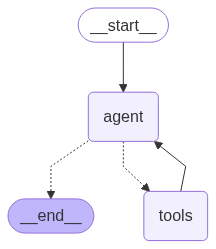

In [172]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass